In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import cv2 
from glob import glob

#General imports
import itertools
import time
import pickle
import warnings
warnings.filterwarnings('ignore')

# KERAS AND SKLEARN MODULES
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import BatchNormalization,GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint,EarlyStopping
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import sklearn.utils as sku
from sklearn.metrics import classification_report
from keras.models import load_model


In [3]:
from tensorflow.keras.applications import mobilenet_v2

In [4]:
dirpath = 'deepweeds/'
dirimg = dirpath + 'images/'
labelsBase = dirpath + 'labels/'
labelsPath = labelsBase + 'labels.csv'
df = pd.read_csv(labelsPath)
df.head()

,Filename,Label,Species
0,20160928-140314-0.jpg,0,Chinee apple
1,20160928-140337-0.jpg,0,Chinee apple
2,20160928-140731-0.jpg,0,Chinee apple
3,20160928-140747-0.jpg,0,Chinee apple
4,20160928-141107-0.jpg,0,Chinee apple


In [6]:
#Split in training and test set with a ratio of 80:20
df_train, df_test = train_test_split(df, test_size=0.2, random_state=7, shuffle=True)

# Preprocessing 

In [7]:
df_train['Label'] = df_train['Label'].astype('str')
df_test['Label'] = df_test['Label'].astype('str')

In [8]:
batch_size = 512
img_dim = 128
num_classes=9
def getImgTensor(img_d):
    return (img_d, img_d, 3)
getImgTensor(img_dim)

(128, 128, 3)

In [9]:
Image_datagen = ImageDataGenerator(rescale=1./255)

train_generator=Image_datagen.flow_from_dataframe(directory=dirimg,
                                                  dataframe=df_train,
                                                  x_col='Filename',
                                                  y_col='Label',
                                                  batch_size=batch_size,
                                                  color_mode="rgb",
                                                  shuffle=True,
                                                  class_mode="categorical",
                                                  target_size=getImgTensor(img_dim)[:2])

Found 14007 validated image filenames belonging to 9 classes.


In [10]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator=test_datagen.flow_from_dataframe(directory=dirimg, 
                                                dataframe=df_test,
                                                x_col='Filename',
                                                y_col='Label',
                                                batch_size=1,
                                                color_mode="rgb",
                                                shuffle=False,
                                                class_mode="categorical",
                                                target_size=getImgTensor(img_dim)[:2])

Found 3502 validated image filenames belonging to 9 classes.


In [12]:
model = Sequential() 
model.add(Conv2D(16, (5,5), activation='relu', input_shape=(img_dim, img_dim, 3))) 
model.add(Conv2D(16, (5, 5), activation='relu')) 
model.add(MaxPooling2D((2, 2))) 
model.add(Conv2D(32, (3, 3), activation='relu')) 
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu')) 
model.add(Conv2D(64, (3, 3), activation='relu')) 
model.add(Flatten()) 
model.add(Dense(256, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 124, 124, 16)      1216      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 120, 120, 16)      6416      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 60, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 58, 58, 32)        4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 26, 26, 64)        1

In [15]:
steps_per_epoch = np.ceil(train_generator.n/train_generator.batch_size)
epochs=15
start=time.time()
my_history=model.fit_generator(generator=train_generator, steps_per_epoch=steps_per_epoch, 
                               epochs=epochs, verbose=1)
print("Total time: ", time.time() - start, "seconds")

Epoch 1/15
28/28 [==============================] - 30s 757ms/step - loss: 1.7741 - accuracy: 0.5028
Epoch 2/15
28/28 [==============================] - 19s 659ms/step - loss: 1.5401 - accuracy: 0.5226
Epoch 3/15
28/28 [==============================] - 20s 679ms/step - loss: 1.4508 - accuracy: 0.5292
Epoch 4/15
28/28 [==============================] - 19s 671ms/step - loss: 1.3654 - accuracy: 0.5419
Epoch 5/15
28/28 [==============================] - 20s 697ms/step - loss: 1.2265 - accuracy: 0.5740
Epoch 6/15
28/28 [==============================] - 20s 692ms/step - loss: 1.1886 - accuracy: 0.5831
Epoch 7/15
28/28 [==============================] - 20s 682ms/step - loss: 1.1401 - accuracy: 0.5988
Epoch 8/15
28/28 [==============================] - 19s 663ms/step - loss: 1.0890 - accuracy: 0.6207
Epoch 9/15
28/28 [==============================] - 19s 664ms/step - loss: 1.0836 - accuracy: 0.6138
Epoch 10/15
28/28 [==============================] - 20s 677ms/step - loss: 1.0202 - accura

In [16]:
model.save('personal_model.h5')

In [14]:
model=load_model('personal_model.h5')

In [17]:
test_steps_per_epoch = int(test_generator.n/test_generator.batch_size)
predictions = model.predict_generator(test_generator, steps=test_steps_per_epoch, verbose=1)

3502/3502 [==============================] - 11s 3ms/step


<AxesSubplot:>

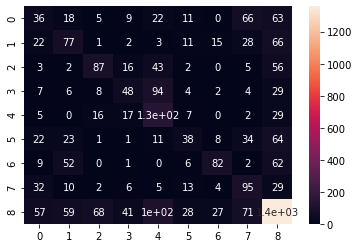

In [18]:
y_predicted=np.argmax(predictions, axis=1).astype('str')
y_true=df_test['Label']
sns.heatmap(confusion_matrix(y_true,y_predicted),annot=True)

In [19]:
confusion_matrix(y_true,y_predicted)

array([[  36,   18,    5,    9,   22,   11,    0,   66,   63],
       [  22,   77,    1,    2,    3,   11,   15,   28,   66],
       [   3,    2,   87,   16,   43,    2,    0,    5,   56],
       [   7,    6,    8,   48,   94,    4,    2,    4,   29],
       [   5,    0,   16,   17,  133,    7,    0,    2,   29],
       [  22,   23,    1,    1,   11,   38,    8,   34,   64],
       [   9,   52,    0,    1,    0,    6,   82,    2,   62],
       [  32,   10,    2,    6,    5,   13,    4,   95,   29],
       [  57,   59,   68,   41,  101,   28,   27,   71, 1358]])

In [20]:
print(classification_report(y_true, y_predicted))

              precision    recall  f1-score   support

           0       0.19      0.16      0.17       230
           1       0.31      0.34      0.33       225
           2       0.46      0.41      0.43       214
           3       0.34      0.24      0.28       202
           4       0.32      0.64      0.43       209
           5       0.32      0.19      0.24       202
           6       0.59      0.38      0.47       214
           7       0.31      0.48      0.38       196
           8       0.77      0.75      0.76      1810

    accuracy                           0.56      3502
   macro avg       0.40      0.40      0.39      3502
weighted avg       0.57      0.56      0.56      3502



In [24]:
#Using Mobile net V2 model and imagenet weights 
#top is not included
img_dim=128
mobilenet = mobilenet_v2.MobileNetV2(weights='imagenet', input_shape=getImgTensor(img_dim), include_top=False)
mobilenet.trainable = False

model_mobilenet = Sequential([
                    mobilenet,
                    GlobalAveragePooling2D(),
                    Dropout(0.3),
                    Dense(256, activation='relu'),
                    Dropout(0.25),
                    Dense(9, activation='softmax')
])
print(model_mobilenet.summary())
model_mobilenet.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_mobilenet.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Functi (None, 4, 4, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               327936    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 9)                 2313      
Total params: 2,588,233
Trainable params: 330,249
Non-trainable params: 2,257,984
______________________________________

In [26]:
epochs=10
start=time.time()
mobilenet_history=model_mobilenet.fit(train_generator, steps_per_epoch=steps_per_epoch, 
                               epochs=epochs ,verbose=1)
print("Total time: ", time.time() - start, "seconds")

Epoch 1/10
28/28 [==============================] - 19s 662ms/step - loss: 0.6144 - accuracy: 0.7778
Epoch 2/10
28/28 [==============================] - 19s 661ms/step - loss: 0.5918 - accuracy: 0.7929
Epoch 3/10
28/28 [==============================] - 19s 660ms/step - loss: 0.5728 - accuracy: 0.7920
Epoch 4/10
28/28 [==============================] - 19s 657ms/step - loss: 0.5570 - accuracy: 0.8024
Epoch 5/10
28/28 [==============================] - 19s 669ms/step - loss: 0.5450 - accuracy: 0.8047
Epoch 6/10
28/28 [==============================] - 19s 669ms/step - loss: 0.5383 - accuracy: 0.8073
Epoch 7/10
28/28 [==============================] - 19s 674ms/step - loss: 0.5170 - accuracy: 0.8117
Epoch 8/10
28/28 [==============================] - 19s 667ms/step - loss: 0.5099 - accuracy: 0.8159
Epoch 9/10
28/28 [==============================] - 19s 676ms/step - loss: 0.4949 - accuracy: 0.8209
Epoch 10/10
28/28 [==============================] - 19s 666ms/step - loss: 0.4898 - accura

In [27]:
model_mobilenet.save('model_mobilenet.h5')
with open('trainHistoryDict_mobilenet', 'wb') as file_pi:
    pickle.dump(mobilenet_history.history, file_pi)

In [28]:
test_steps_per_epoch = int(test_generator.n/test_generator.batch_size)
predictions = model_mobilenet.predict_generator(test_generator, steps=test_steps_per_epoch, verbose=1)

3502/3502 [==============================] - 41s 11ms/step


<AxesSubplot:>

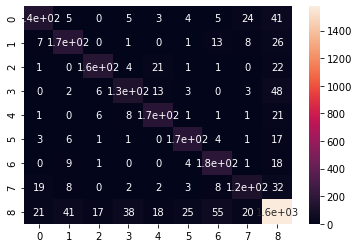

In [29]:
y_predicted=np.argmax(predictions, axis=1).astype('str')
y_true=df_test['Label']
sns.heatmap(confusion_matrix(y_true,y_predicted),annot=True)

In [30]:
confusion_matrix(y_true,y_predicted)

array([[ 143,    5,    0,    5,    3,    4,    5,   24,   41],
       [   7,  169,    0,    1,    0,    1,   13,    8,   26],
       [   1,    0,  164,    4,   21,    1,    1,    0,   22],
       [   0,    2,    6,  127,   13,    3,    0,    3,   48],
       [   1,    0,    6,    8,  170,    1,    1,    1,   21],
       [   3,    6,    1,    1,    0,  169,    4,    1,   17],
       [   0,    9,    1,    0,    0,    4,  181,    1,   18],
       [  19,    8,    0,    2,    2,    3,    8,  122,   32],
       [  21,   41,   17,   38,   18,   25,   55,   20, 1575]])

In [31]:
print(classification_report(y_true, y_predicted))

              precision    recall  f1-score   support

           0       0.73      0.62      0.67       230
           1       0.70      0.75      0.73       225
           2       0.84      0.77      0.80       214
           3       0.68      0.63      0.65       202
           4       0.75      0.81      0.78       209
           5       0.80      0.84      0.82       202
           6       0.68      0.85      0.75       214
           7       0.68      0.62      0.65       196
           8       0.88      0.87      0.87      1810

    accuracy                           0.81      3502
   macro avg       0.75      0.75      0.75      3502
weighted avg       0.81      0.81      0.80      3502

